## Week 3
Using Ciera Martinez's map_motif.py in a generalized jupyter notebook function.

Author: Jemima Shi

In [87]:
import numpy as np
import pandas as pd
import re
import Bio
from Bio import SeqIO
from glob import glob
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys
from Bio import motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC, generic_dna, generic_protein
from collections import defaultdict

In [2]:
#Reads through and saves the names of all same files(.fa and .fm respectively) found in the same directory.

files = glob('*.fa')
all_motifs = glob('*.fm')

In [3]:

def read_records(file):
    """
    file: a single .fa file within the directory.
    
    Returns the records from a .fa file as a list .
    """
    return list(SeqIO.parse(file, "fasta"))

In [4]:

def read_motif(motif):
    """
    motif: a single .fm file within the directory.
    
    Returns a motif.jaspar.Motif (the motif matrix) from the .fm file.
    """
    return motifs.read(open(motif), "pfm")

In [5]:
first_file = read_records(files[0])
first_motif = read_motif(all_motifs[0])

In [6]:

def raw_sequence_ungap(records):
    """
    records: a list of species within a single .fa file.
    
    Returns a list of Sequences with an ungapped('-') sequence.
    """
    raw_sequences = []
    for record in records:
        raw_sequences.append(SeqRecord(record.seq.ungap("-"), id = record.id))
    return raw_sequences

In [7]:

def cast_sequence(ungapped_sequence):
    """
    ungapped_sequence: a list with the sequence and id for all the species in a file.
    
    Returns a list sequences with the type cast as IUPACUnambiguousDNA().
    """
    casted = []
    for record in ungapped_sequence:
        casted.append(Seq(str(record.seq), IUPAC.IUPACUnambiguousDNA()))
    return casted

In [8]:
first_raw = raw_sequence_ungap(first_file)
first_raw

[SeqRecord(seq=Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCCCATCCAACCAACCAAC...TTG', SingleLetterAlphabet()), id='VT0809|1|MEMB005D|-|2314', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCCCATCCAACCAACCAAC...TTG', SingleLetterAlphabet()), id='VT0809|1|MEMB006A|-|2603', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCACACCAACCAACCATCC...TTG', SingleLetterAlphabet()), id='VT0809|1|MEMB007D|+|2525', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCATCCATCCATCC...TTG', SingleLetterAlphabet()), id='VT0809|1|MEMB002F|+|2568', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CTGCGTGCCACAGAACGCCCTTGCAACCACGCAACCCCCGCCCAAAGCCGGCTA...TTG', SingleLetterAlphabet()), id='VT0809|1|MEMB007B|-|2240', name='<unknow

In [9]:
first_cast = cast_sequence(first_raw)
first_cast

[Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCCCATCCAACCAACCAAC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCCCATCCAACCAACCAAC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCACACCAACCAACCATCC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCATCCATCCATCC...TTG', IUPACUnambiguousDNA()),
 Seq('CTGCGTGCCACAGAACGCCCTTGCAACCACGCAACCCCCGCCCAAAGCCGGCTA...TTG', IUPACUnambiguousDNA()),
 Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCAGCCCATCCATC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCAGCCCATCCATC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCAGCCCATCCATC...TTG', IUPACUnambiguousDNA()),
 Seq('TTTCAACCCAATTTCCTAGGACTCACAGCCATACCCTGTGTGCCACCTTAGCTA...TTG', IUPACUnambiguousDNA()),
 Seq('CGCAACATCAGCCAAGCATAAAGCTCAGCCCCATCGCACACCAGCCATCCATCC...TTG', IUPACUnambiguousDNA()),
 Seq('CGCTACATCAGCCAAGCAGAAAGCTCAGCCCCATCGCACATCAACCAACCATCC...TTG', I

In [10]:

def calculate_pssm(chosen_motif, pseudocounts=0.0):
    """
    chosen_motif: Chosen motif sequence to be used in creating the pwm
    pseudocounts: Default set to 0.0, otherwise added to the counts before calculating position-weight matrix.
    
    Returns the pssm (PositionSpecificScoringMatrix)
    """
    pwm = chosen_motif.counts.normalize(pseudocounts)
    return pwm.log_odds()

In [11]:

def pwm_threshold(cast_sequences):
    """
    cast_sequences: A list of sequences that have been ungapped and casted.
    
    Returns a list of pssm values
    """
    pssm = calculate_pssm(raw_sequences)
    pssm_list = [ ]
    for seq in cast_sequences:
        pssm_list.append(pssm.calculate(seq))
    return pssm_list

In [12]:

def extract_len_id(raw_sequences):
    """
    raw_sequences: A list of raw sequences that hasn't yet cast.
    
    Returns a list of dictionary pairs for the species and seq_len of each sequence.
    """
    raw_id = []
    record_length = []
    for seq in raw_sequences:
        try:
            raw_id.append(seq.id)
            record_length.append(len(seq))
        except AttributeError:
            raw_id.append('n/a')
            record_length.append(len(seq))
    return [{'species': x, 'seq_len': y} for x, y in zip(raw_id, record_length)]

In [13]:

def positions(raw_sequence, cast_sequences, motif, chosen_precision=10**4):
    """
    raw_sequence: A list of the sequences that have been ungapped but not casted.
    cast_sequences: A list of sequences that have been ungapped and casted.
    motif: the chosen motif file read in using read_motif
    precision: default precision set to 10**4 to be used in the pssm distribution.
    
    Returns a list of positions
    """
    pssm = calculate_pssm(motif)
    distribution = pssm.distribution(background=motif.background, precision= chosen_precision)
    patser_threshold = distribution.threshold_patser()
    
    position_list = []
    len_and_ids = extract_len_id(raw_sequence)
    for i in range(0,8): #number of gene sequences 
        for position, score in pssm.search(cast_sequences[i], patser_threshold):
            positions = {'species': len_and_ids[i].get('species'), 'score':score, 
                         'position':position, 'seq_len': len_and_ids[i].get('seq_len') }
            position_list.append(positions)
    return position_list

In [14]:

def positive_positions(df):
    """
    df: The df with position, score, seq_len, and species.
    
    Returns a df where the position arguments are translated into positive ints.
    """
    temp_pos = df[df["position"] >= 0].copy()
    temp_neg = df[df["position"] < 0].copy()
    temp_pos["raw_position"] = temp_pos["position"]
    temp_neg["raw_position"] = temp_neg["seq_len"] + temp_neg["position"]  
    temp_together = temp_pos.append(temp_neg).reset_index().sort_values("index")

    return temp_together.set_index("index")

In [15]:

def define_sign(df):
    """
    df: The df with position, score, seq_len, species, and raw_position.
    
    Returns the df with a strand sign column appended on.
    """
    df["strand"] = np.where(df['position'] >= 0, 'positive', 'negative')
    return df

In [16]:
test_df = pd.DataFrame(positions(first_raw, first_cast, first_motif))
t = positive_positions(test_df)
t = define_sign(t)

In [17]:

def merge_align_df(raw_df, aligned_seq):
    """
    raw_df: A pandas df that contains the positions, score, seq_len, species, and strand orientation.
    aligned_seq: Original inputted sequence with the '-' still included.
    
    Returns a df with alignned index appended to raw_df sorted by ['species', 'raw_position'] 
    with N/A values dropped.
    
    """
    remap_list = []
    nuc_list = ['A', 'a', 'G', 'g', 'C', 'c', 'T', 't', 'N', 'n']

    for i in range(0,9):
        counter = 0
        for xInd, x in enumerate(aligned_seq[i].seq):    
            if x in nuc_list:
                remaps = {'raw_position': counter, 'align_position':xInd, 'species':aligned_seq[i].id}
                counter += 1
                remap_list.append(remaps)
            
    remap_DF = pd.DataFrame(remap_list)
    TFBS_map_DF_all = pd.merge(raw_df, remap_DF, on=['species', 'raw_position'], how='outer')
    TFBS_map_DF_all = TFBS_map_DF_all.sort_values(by=['species','align_position'], ascending=[True, True])

    return TFBS_map_DF_all.dropna()   

In [18]:
temp = merge_align_df(t, first_file)

In [19]:

def save_df(TFBS_df, align_file, motif_file):
    """
    TFBS_df: A pandas df with the raw/aligned position, score, and file names.
    align_file: Name of read in alignment file.
    motif_file: Name of read in motif file.
    
    Returns a csv copy of the df stored in the current directory
    """
    return TFBS_df.to_csv('map_motif ' + align_file + "-" + motif_file + ".csv", sep='\t', na_rep="NA")

In [20]:

def caluclate_all_TFBS(files, all_motifs):
    """
    files: A list of all the .fa files in the current directory.
    all_motifs: A list of all the .fm files in the current directory.
    
    Returns a csv with the positions, score, and orientation saved into the current directory for all files.
    """
    for file in files:
        for motif in all_motifs:
            curr_file = read_records(file)
            curr_motif = read_motif(motif)
            curr_raw = raw_sequence_ungap(curr_file)
            curr_cast = cast_sequence(curr_raw)
            
            raw_df = pd.DataFrame(positions(curr_raw, curr_cast, curr_motif))
            temp_df = positive_positions(raw_df)
            temp_df = define_sign(temp_df)
            
            align_name = re.split(r'_', files[0])[-1]
            save_df(merge_align_df(temp_df, curr_file), align_name, motif)

In [52]:
#Run this cell to generate a csv file for all the files with all the possible motif files.

caluclate_all_TFBS(files, all_motifs)

### Current attemps at graphing to be added on to-

In [49]:
temp

,position,score,seq_len,species,raw_position,strand,align_position
6671,-2381.0,0.654739,2381.0,VT0809|1|MEMB002A|-|2381,0,negative,0
6672,2.0,1.590609,2381.0,VT0809|1|MEMB002A|-|2381,2,positive,2
6673,7.0,4.699133,2381.0,VT0809|1|MEMB002A|-|2381,7,positive,7
6674,11.0,0.368217,2381.0,VT0809|1|MEMB002A|-|2381,11,positive,11
6675,12.0,2.529208,2381.0,VT0809|1|MEMB002A|-|2381,12,positive,12
6676,-2365.0,1.462094,2381.0,VT0809|1|MEMB002A|-|2381,16,negative,16
6677,18.0,2.982926,2381.0,VT0809|1|MEMB002A|-|2381,18,positive,18
6678,19.0,1.529209,2381.0,VT0809|1|MEMB002A|-|2381,19,positive,19
6679,-2358.0,2.114171,2381.0,VT0809|1|MEMB002A|-|2381,23,negative,23
6680,24.0,4.699133,2381.0,VT0809|1|MEMB002A|-|2381,24,positive,24


In [78]:
species = temp["species"].unique()

In [80]:
to_plot = temp[temp["species"] == species[0]]

In [93]:
go = to_plot[["score", "raw_position"]]
go2 = to_plot[["score", "align_position"]]

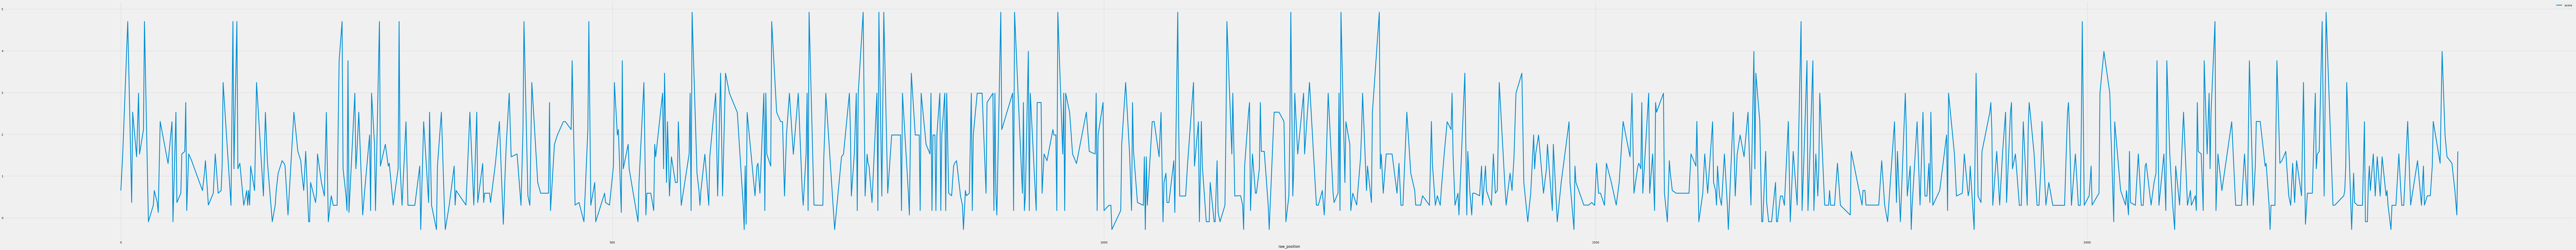

In [102]:
go.plot(x= "raw_position", figsize= (200, 20))

In [62]:
from IPython.core.display import display, HTML

In [65]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [ ]:
HTML('''<!DOCTYPE html>
<meta charset="utf-8">
<style>

    body {
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
        width: 960px;
        height: 500px;
        position: relative;
    }

    svg {
        width: 100%;
        height: 100%;
        position: center;
    }

    .toolTip {
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
        position: absolute;
        display: none;
        width: auto;
        height: auto;
        background: none repeat scroll 0 0 white;
        border: 0 none;
        border-radius: 8px 8px 8px 8px;
        box-shadow: -3px 3px 15px #888888;
        color: black;
        font: 12px sans-serif;
        padding: 5px;
        text-align: center;
    }

    text {
        font: 10px sans-serif;
        color: white;
    }
    text.value {
        font-size: 120%;
        fill: white;
    }

    .axisHorizontal path{
        fill: none;
    }

    .axisHorizontal .tick line {
        stroke-width: 1;
        stroke: rgba(0, 0, 0, 0.2);
    }

    .bar {
        fill: steelblue;
        fill-opacity: .9;
    }

</style>
<body>

<script src="http://d3js.org/d3.v3.min.js"></script>
<script>

    data = [
        {label:"Category 1", value:19, seq: "ACTG"},
        {label:"Category 2", value:5, seq: "ACTG"},
        {label:"Category 3", value:13, seq: "ACTG"},
        {label:"Category 4", value:17, seq: "ACTG"},
        {label:"Category 5", value:19, seq: "ACTG"},
        {label:"Category 6", value:10, seq: "ACTG"}
    ];


    var div = d3.select("body").append("div").attr("class", "toolTip");

    var axisMargin = 20,
            margin = 40,
            valueMargin = 4,
            width = parseInt(d3.select('body').style('width'), 10),
            height = parseInt(d3.select('body').style('height'), 10),
            barHeight = (height-axisMargin-margin*2)* 0.4/data.length,
            barPadding = (height-axisMargin-margin*2)*0.6/data.length,
            data, bar, svg, scale, xAxis, labelWidth = 0;

    max = d3.max(data, function(d) { return d.value; });

    svg = d3.select('body')
            .append("svg")
            .attr("width", width)
            .attr("height", height);


    bar = svg.selectAll("g")
            .data(data)
            .enter()
            .append("g");

    bar.attr("class", "bar")
            .attr("cx",0)
            .attr("transform", function(d, i) {
                return "translate(" + margin + "," + (i * (barHeight + barPadding) + barPadding) + ")";
            });

    bar.append("text")
            .attr("class", "label")
            .attr("y", barHeight / 2)
            .attr("dy", ".35em") //vertical align middle
            .text(function(d){
                return d.label;
            }).each(function() {
        labelWidth = Math.ceil(Math.max(labelWidth, this.getBBox().width));
    });

    scale = d3.scale.linear()
            .domain([0, max])
            .range([0, width - margin*2 - labelWidth]);

    xAxis = d3.svg.axis()
            .scale(scale)
            .tickSize(-height + 2*margin + axisMargin)
            .orient("bottom");

    bar.append("rect")
            .attr("transform", "translate("+labelWidth+", 0)")
            .attr("height", barHeight)
            .attr("width", function(d){
                return scale(d.value);
            });

    bar.append("text")
            .attr("class", "value")
            .attr("y", barHeight / 2)
            .attr("dx", -valueMargin + labelWidth) //margin right
            .attr("dy", ".35em") //vertical align middle
            .attr("text-anchor", "end")
            .text(function(d){
                return (d.seq+"%");
            })
            .attr("x", function(d){
                var width = this.getBBox().width;
                return Math.max(width + valueMargin, scale(d.value));
            });


    svg.insert("g",":first-child")
            .attr("class", "axisHorizontal")
            .attr("transform", "translate(" + (margin + labelWidth) + ","+ (height - axisMargin - margin)+")")
            .call(xAxis);

</script>
</body>''')